## Part 2 Collaborative Filtering

Time: ~10 h

### Read Data

In [2]:
import pandas as pd

In [3]:
ratings = pd.read_csv('ratings.csv', \
                      usecols = ['user_id', 'item_id', 'user_emb_id', \
                                 'item_emb_id', 'score'])

max_user = ratings['user_id'].drop_duplicates().max()
max_item = ratings['item_id'].drop_duplicates().max()
print(max_user, max_item)

22362 12100


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2)
train.head()

,user_id,item_id,score,user_emb_id,item_emb_id
147107,16554,9529,5.0,16554,9529
21032,9066,1389,3.0,9066,1389
32995,11344,2267,5.0,11344,2267
112359,2596,7520,5.0,2596,7520
76845,12852,5191,4.0,12852,5191


### Setup Model

In [6]:
import numpy as np
import keras
from keras.layers import Input, Embedding, merge, Dot, Dropout, Dense, Flatten
from keras.models import Sequential

In [7]:
def Cf_dot_model(max_user, max_item, emb_size=50, dropout_rate = 0.2):
    # user part
    user_input = Input(shape=[1],name='user')
    user_emb = Embedding(max_user+1, emb_size, name='User_embedding')(user_input)
    user_vec = Flatten(name='FlattenUserEmbedding')(user_emb)

    
    # item part
    item_input = Input(shape=[1],name='item')
    item_emb = Embedding(max_item+1, emb_size, name='Item_embedding')(item_input)
    item_vec = Flatten(name='FlattenItemEmbedding')(item_emb)
    
    # dot merge
    merge = Dot(axes = 1)([user_vec, item_vec])
    
    # deep model
    full_connect = Dense(emb_size, activation = 'relu')(merge)
    drop_1 = Dropout(dropout_rate)(full_connect)
#     dense_1 = Dense(16, activation = 'relu')(drop_1)
#     drop_2 = Dropout(dropout_rate)(dense_1)
    result = Dense(1, activation = 'linear')(drop_1)
    
    return keras.Model([user_input, item_input], result)

In [19]:
cfmodel = Cf_dot_model(max_user, max_item)

In [20]:
cfmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User_embedding (Embedding)      (None, 1, 50)        1118150     user[0][0]                       
__________________________________________________________________________________________________
Item_embedding (Embedding)      (None, 1, 50)        605050      item[0][0]                       
__________________________________________________________________________________________________
FlattenUse

### Parameters Tuning on Embedding_Size

In [21]:
history = {}
for emb in [50, 100, 150]:
    cfmodel = Cf_dot_model(max_user, max_item, emb)
    cfmodel.compile(optimizer='adam',loss= 'mean_absolute_error')
    history[emb] = cfmodel.fit([train.user_id, train.item_id], train.score, 
                               epochs = 3, validation_split = 0.2, verbose =0)

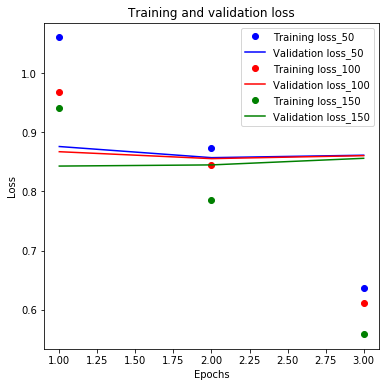

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
color = ['blue','red','green']
i = 0
for key in history:
    history_dict = history[key].history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, 4)
    plt.plot(epochs, loss_values, 'bo', label='Training loss_'+str(key), color = color[i])
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss_'+str(key), color = color[i])
    i += 1

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

This is a very basic model, and from the result above we can see the emb_size = 150 is the best embedding size. Besides, the appropiate epochs should be around 2. 

### Train the final model

In [8]:
final_model = Cf_dot_model(max_user, max_item, emb_size=150)
final_model.compile(optimizer='adam',loss= 'mean_absolute_error')
check = final_model.fit([train.user_id, train.item_id], train.score, 
            epochs = 3, validation_split = 0.2, verbose =0)

In [9]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(test.score, final_model.predict([test.user_id, test.item_id]))
print('mean absolute error in test set is %f' %error)

mean absolute error in test set is 0.816255


In [10]:
# save final model
from keras.models import load_model
final_model.save('final_model.h5')